# 🚀 Classificação de Sentimento com BERT

**Objetivo:** Treinar 3 modelos BERT (`neuralmind/bert-base-portuguese-cased`) para classificar o sentimento (positivo, negativo ou neutro) de comentários sobre 3 tópicos distintos: "Onça", "Caseiro" e "Notícia".

**Autor:** Lucas Vinicius da Luz Ferreira

In [1]:
!pip install transformers torch

In [2]:
import torch
import time
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AutoConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

## 1. 🧹 Preparação dos Dados

Nesta etapa, foi feito todo o pré-processamento dos dados:
1.  Foi carregado o arquivo CSV usando o Pandas.
2.  Foi removida as linhas com textos vazios ou duplicados.
3.  Foram convertidos os rótulos de texto (ex: "negativo", "neutro", "positivo") para números (0, 1, 2) para cada uma das 3 classes.
4.  Foi dividido o DataFrame *inteiro* (85% / 15%) e depois (70% / 15%) para criar os conjuntos de **Treino (70%)**, **Validação (15%)** e **Teste (15%)**.
    * Usar `train_test_split` no DataFrame garante que não há **vazamento de dados (data leakage)**, pois o mesmo comentário estará sempre no mesmo conjunto para os 3 modelos.

In [3]:
url = "https://docs.google.com/spreadsheets/d/17aHYyRNfbmde8bVOR_HX_BmNUEdkygPuaGO4lJj26jg/export?format=csv&gid=0"
planilha = pd.read_csv(url)

planilha_filtrada = planilha[
      planilha['onca'].notna() & (planilha['onca'].str.strip() != "")
    & planilha['caseiro'].notna() & (planilha['caseiro'].str.strip() != "")
    & planilha['notícia'].notna() & (planilha['notícia'].str.strip() != "")
    & planilha['comment_text'].notna() & (planilha['comment_text'].str.strip() != "")
]

planilha_final = planilha_filtrada.drop_duplicates(subset=['comment_text'])

mapeamento = {'positivo': 2, 'neutro': 1, 'negativo': 0}

planilha_final['onca'] = planilha_final['onca'].str.lower().str.strip().map(mapeamento)
planilha_final['caseiro'] = planilha_final['caseiro'].str.lower().str.strip().map(mapeamento)
planilha_final['notícia'] = planilha_final['notícia'].str.lower().str.strip().map({'boa': 2, 'neutra': 1, 'ruim': 0})

/tmp/ipython-input-49290947.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planilha_final['onca'] = planilha_final['onca'].str.lower().str.strip().map(mapeamento)
/tmp/ipython-input-49290947.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planilha_final['caseiro'] = planilha_final['caseiro'].str.lower().str.strip().map(mapeamento)
/tmp/ipython-input-49290947.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [4]:
temp_restante, temp_teste = train_test_split(planilha_final, test_size=0.15, random_state=42, stratify=planilha_final['onca'])
temp_treino, temp_valid = train_test_split(temp_restante, test_size=0.17647, random_state=42, stratify=temp_restante['onca'])

# Onca
X_treino_onca, y_treino_onca = temp_treino['comment_text'], temp_treino['onca']
X_valid_onca, y_valid_onca = temp_valid['comment_text'], temp_valid['onca']
X_teste_onca, y_teste_onca = temp_teste['comment_text'], temp_teste['onca']
# Caseiro
X_treino_caseiro, y_treino_caseiro = temp_treino['comment_text'], temp_treino['caseiro']
X_valid_caseiro, y_valid_caseiro = temp_valid['comment_text'], temp_valid['caseiro']
X_teste_caseiro, y_teste_caseiro = temp_teste['comment_text'], temp_teste['caseiro']
# Noticia
X_treino_noticia, y_treino_noticia = temp_treino['comment_text'], temp_treino['notícia']
X_valid_noticia, y_valid_noticia = temp_valid['comment_text'], temp_valid['notícia']
X_teste_noticia, y_teste_noticia = temp_teste['comment_text'], temp_teste['notícia']

## 2. Tokenização e DataLoaders

Com os dados divididos, os mesmos foram preparados para o BERT:
1.  Foi instaciado o `AutoTokenizer` do modelo `neuralmind/bert-base-portuguese-cased`.
2.  Foi criada uma função que converte as listas de comentários em tensores PyTorch:
    * `input_ids`: Os IDs de cada token (palavra).
    * `attention_mask`: A máscara que diz ao modelo quais tokens são palavras reais e quais são preenchimento (`[PAD]`).
3.  Foram Empacotados os tensores (`input_ids`, `attention_mask` e `rotulos`) em `TensorDataset` e, em seguida, em `DataLoader`. Isso permite que o modelo acesse os dados em lotes (`BATCH_SIZE`) durante o treinamento.
    * Foram criados 9 DataLoaders no total (treino/val/teste para Onça, Caseiro e Notícia).

In [5]:
MODELO = 'neuralmind/bert-base-portuguese-cased'

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Usando GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('Usando CPU (O treinamento será lento).')

tokenizador = AutoTokenizer.from_pretrained(MODELO)

MAX = 128
BATCH_SIZE = 16

def codificar_textos(tokenizador, texto, maximo):
    encoded_batch = tokenizador.batch_encode_plus(
        texto.tolist(),
        add_special_tokens=True,
        max_length=maximo,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

# Onca
input_ids_treino_onca, attention_masks_treino_onca = codificar_textos(tokenizador, X_treino_onca, MAX)
input_ids_valid_onca, attention_masks_valid_onca = codificar_textos(tokenizador, X_valid_onca, MAX)
input_ids_teste_onca, attention_masks_teste_onca = codificar_textos(tokenizador, X_teste_onca, MAX)

rotulos_treino_onca = torch.tensor(y_treino_onca.values)
rotulos_valid_onca = torch.tensor(y_valid_onca.values)
rotulos_teste_onca = torch.tensor(y_teste_onca.values)

dataset_treino_onca = TensorDataset(input_ids_treino_onca, attention_masks_treino_onca, rotulos_treino_onca)
dataset_valid_onca = TensorDataset(input_ids_valid_onca, attention_masks_valid_onca, rotulos_valid_onca)
dataset_teste_onca = TensorDataset(input_ids_teste_onca, attention_masks_teste_onca, rotulos_teste_onca)

dataloader_treino_onca = DataLoader(
    dataset_treino_onca,
    sampler=RandomSampler(dataset_treino_onca),
    batch_size=BATCH_SIZE
)

dataloader_valid_onca = DataLoader(
    dataset_valid_onca,
    sampler=SequentialSampler(dataset_valid_onca),
    batch_size=BATCH_SIZE
)

dataloader_teste_onca = DataLoader(
    dataset_teste_onca,
    sampler=SequentialSampler(dataset_teste_onca),
    batch_size=BATCH_SIZE
)

# Caseiro
input_ids_treino_caseiro, attention_masks_treino_caseiro = codificar_textos(tokenizador, X_treino_caseiro, MAX)
input_ids_valid_caseiro, attention_masks_valid_caseiro = codificar_textos(tokenizador, X_valid_caseiro, MAX)
input_ids_teste_caseiro, attention_masks_teste_caseiro = codificar_textos(tokenizador, X_teste_caseiro, MAX)

rotulos_treino_caseiro = torch.tensor(y_treino_caseiro.values)
rotulos_valid_caseiro = torch.tensor(y_valid_caseiro.values)
rotulos_teste_caseiro = torch.tensor(y_teste_caseiro.values)

dataset_treino_caseiro = TensorDataset(input_ids_treino_caseiro, attention_masks_treino_caseiro, rotulos_treino_caseiro)
dataset_valid_caseiro = TensorDataset(input_ids_valid_caseiro, attention_masks_valid_caseiro, rotulos_valid_caseiro)
dataset_teste_caseiro = TensorDataset(input_ids_teste_caseiro, attention_masks_teste_caseiro, rotulos_teste_caseiro)

dataloader_treino_caseiro = DataLoader(
    dataset_treino_caseiro,
    sampler=RandomSampler(dataset_treino_caseiro),
    batch_size=BATCH_SIZE
)

dataloader_valid_caseiro = DataLoader(
    dataset_valid_caseiro,
    sampler=SequentialSampler(dataset_valid_caseiro),
    batch_size=BATCH_SIZE
)

dataloader_teste_caseiro = DataLoader(
    dataset_teste_caseiro,
    sampler=SequentialSampler(dataset_teste_caseiro),
    batch_size=BATCH_SIZE
)

# Noticia
input_ids_treino_noticia, attention_masks_treino_noticia = codificar_textos(tokenizador, X_treino_noticia, MAX)
input_ids_valid_noticia, attention_masks_valid_noticia = codificar_textos(tokenizador, X_valid_noticia, MAX)
input_ids_teste_noticia, attention_masks_teste_noticia = codificar_textos(tokenizador, X_teste_noticia, MAX)

rotulos_treino_noticia = torch.tensor(y_treino_noticia.values)
rotulos_valid_noticia = torch.tensor(y_valid_noticia.values)
rotulos_teste_noticia = torch.tensor(y_teste_noticia.values)

dataset_treino_noticia = TensorDataset(input_ids_treino_noticia, attention_masks_treino_noticia, rotulos_treino_noticia)
dataset_valid_noticia = TensorDataset(input_ids_valid_noticia, attention_masks_valid_noticia, rotulos_valid_noticia)
dataset_teste_noticia = TensorDataset(input_ids_teste_noticia, attention_masks_teste_noticia, rotulos_teste_noticia)

dataloader_treino_noticia = DataLoader(
    dataset_treino_noticia,
    sampler=RandomSampler(dataset_treino_noticia),
    batch_size=BATCH_SIZE
)

dataloader_valid_noticia = DataLoader(
    dataset_valid_noticia,
    sampler=SequentialSampler(dataset_valid_noticia),
    batch_size=BATCH_SIZE
)

dataloader_teste_noticia = DataLoader(
    dataset_teste_noticia,
    sampler=SequentialSampler(dataset_teste_noticia),
    batch_size=BATCH_SIZE
)

Usando GPU: Tesla T4


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## 3. Definição do Modelo

Aqui, foi carregada a arquitetura do modelo BERT pré-treinado:
1.  Foi usado `AutoConfig` para definir o número de rótulos de saída: `num_labels=3`.
2.  Foi usado `BertForSequenceClassification`. Esta arquitetura já usa o token `[CLS]` (que representa a frase inteira) por padrão para a tarefa de classificação.
3.  Foram criadas **3 instâncias independentes** do modelo (`modelo_onca`, `modelo_caseiro`, `modelo_noticia`) e as movemos para o `device` (GPU).

In [6]:
parametro = AutoConfig.from_pretrained(
    MODELO,
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)

modelo_onca = BertForSequenceClassification.from_pretrained(
    MODELO,
    config=parametro
)

modelo_caseiro = BertForSequenceClassification.from_pretrained(
    MODELO,
    config=parametro
)

modelo_noticia = BertForSequenceClassification.from_pretrained(
    MODELO,
    config=parametro
)

modelo_onca.to(device)
modelo_caseiro.to(device)
modelo_noticia.to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 4. Treinamento e Validação

Esta é a etapa principal onde os modelos aprendem:
1.  Foi criada a função `treinar_modelo` que recebe um modelo e seus dataloaders.
2.  Foi usado o `AdamW` com a taxa de aprendizado (`lr`) de `2e-5`.
3.  Foram iterados por 10 épocas.
    Foi calculado o `loss` e a acurácia nos dados de treino.
    O `loss` e a acurácia foram calculados nos dados de validação para monitorar o aprendizado.
4.  Foi chamada a função `treinar_modelo` 3 vezes, uma para cada modelo.
5.  Exibimos nos gráficos a evolução do *Loss* (Treino vs. Validação) para analisar visualmente.

In [7]:
def formatar_tempo(segundos):
    return str(datetime.timedelta(seconds=int(round(segundos))))

def treinar_modelo(modelo, dataloader_treino, dataloader_valid, device, epocas):
    otimizador = AdamW(modelo.parameters(), lr=2e-5, eps=1e-8)
    total_passos = len(dataloader_treino) * epocas
    lr_scheduler = get_linear_schedule_with_warmup(otimizador,
                                                num_warmup_steps=0,
                                                num_training_steps=total_passos)

    estatisticas = []

    print(f'Iniciando treinamento por {epocas} épocas')

    for epoca in range(1, epocas + 1):
        print(f'\n Época {epoca}/{epocas}')
        epoca_ini = time.time()

        # TREINO
        modelo.train()
        treino_loss_soma = 0.0
        treino_acertos = 0
        treino_amostras = 0

        for batch in dataloader_treino:
            input_ids, attention_mask, rotulos = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            rotulos = rotulos.to(device)

            otimizador.zero_grad()

            outputs = modelo(input_ids,
                            token_type_ids=None,
                            attention_mask=attention_mask,
                            labels=rotulos)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            torch.nn.utils.clip_grad_norm_(modelo.parameters(), 1.0)
            otimizador.step()
            lr_scheduler.step()

            batch_size = rotulos.size(0)
            treino_loss_soma += loss.item() * batch_size

            preds = torch.argmax(logits, dim=1)
            treino_acertos += (preds == rotulos).sum().item()
            treino_amostras += batch_size

        avg_treino_loss = treino_loss_soma / treino_amostras
        treino_acuracia = treino_acertos / treino_amostras

        # VALIDAÇÃO
        modelo.eval()
        valid_loss_soma = 0.0
        valid_acertos = 0
        valid_amostras = 0

        with torch.no_grad():
            for batch in dataloader_valid:
                input_ids, attention_mask, rotulos = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                rotulos = rotulos.to(device)

                outputs = modelo(input_ids,
                                token_type_ids=None,
                                attention_mask=attention_mask,
                                labels=rotulos)
                loss = outputs.loss
                logits = outputs.logits

                batch_size = rotulos.size(0)
                valid_loss_soma += loss.item() * batch_size

                preds = torch.argmax(logits, dim=1)
                valid_acertos += (preds == rotulos).sum().item()
                valid_amostras += batch_size

        avg_valid_loss = valid_loss_soma / valid_amostras
        valid_accuracy = valid_acertos / valid_amostras

        epoca_time = formatar_tempo(time.time() - epoca_ini)

        print(f'Treino Loss: {avg_treino_loss:.4f} | Treino Acc: {treino_acuracia:.4f}')
        print(f'Validação Loss: {avg_valid_loss:.4f} | Validação Acc: {valid_accuracy:.4f}')
        print(f'Tempo da época: {epoca_time}')

        estatisticas.append({
            'epoca': epoca,
            'treino_loss': avg_treino_loss,
            'valid_loss': avg_valid_loss,
            'treino_acc': treino_acuracia,
            'valid_acc': valid_accuracy,
            'epoca_time': epoca_time
        })

    print('Treinamento concluído.')
    return estatisticas

def grafico_loss(estatisticas):
    estatisticas_df = pd.DataFrame(data=estatisticas)
    estatisticas_df = estatisticas_df.set_index('epoca')

    plt.figure(figsize=(10, 5))
    plt.plot(estatisticas_df['treino_loss'], 'b-o', label='Treino')
    plt.plot(estatisticas_df['valid_loss'], 'g-o', label='Validação')

    plt.title('Evolução do Loss (Treino vs. Validação)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, len(estatisticas_df) + 1))
    plt.show()

In [8]:
EPOCA = 10

estatistica_onca = treinar_modelo(
    modelo_onca,
    dataloader_treino_onca,
    dataloader_valid_onca,
    device,
    EPOCA
)

estatistica_caseiro = treinar_modelo(
    modelo_caseiro,
    dataloader_treino_caseiro,
    dataloader_valid_caseiro,
    device,
    EPOCA
)

estatistica_noticia = treinar_modelo(
    modelo_noticia,
    dataloader_treino_noticia,
    dataloader_valid_noticia,
    device,
    EPOCA
)

Iniciando treinamento por 10 épocas

 Época 1/10
Treino Loss: 0.6002 | Treino Acc: 0.7529
Validação Loss: 0.5550 | Validação Acc: 0.7778
Tempo da época: 0:01:13

 Época 2/10
Treino Loss: 0.4052 | Treino Acc: 0.8385
Validação Loss: 0.5439 | Validação Acc: 0.7881
Tempo da época: 0:01:12

 Época 3/10
Treino Loss: 0.2349 | Treino Acc: 0.9202
Validação Loss: 0.7707 | Validação Acc: 0.7926
Tempo da época: 0:01:12

 Época 4/10
Treino Loss: 0.1376 | Treino Acc: 0.9590
Validação Loss: 1.0425 | Validação Acc: 0.7719
Tempo da época: 0:01:12

 Época 5/10
Treino Loss: 0.0781 | Treino Acc: 0.9777
Validação Loss: 1.0894 | Validação Acc: 0.7926
Tempo da época: 0:01:12

 Época 6/10
Treino Loss: 0.0336 | Treino Acc: 0.9917
Validação Loss: 1.1979 | Validação Acc: 0.7881
Tempo da época: 0:01:12

 Época 7/10
Treino Loss: 0.0171 | Treino Acc: 0.9955
Validação Loss: 1.3141 | Validação Acc: 0.7956
Tempo da época: 0:01:12

 Época 8/10
Treino Loss: 0.0113 | Treino Acc: 0.9971
Validação Loss: 1.3271 | Validação 

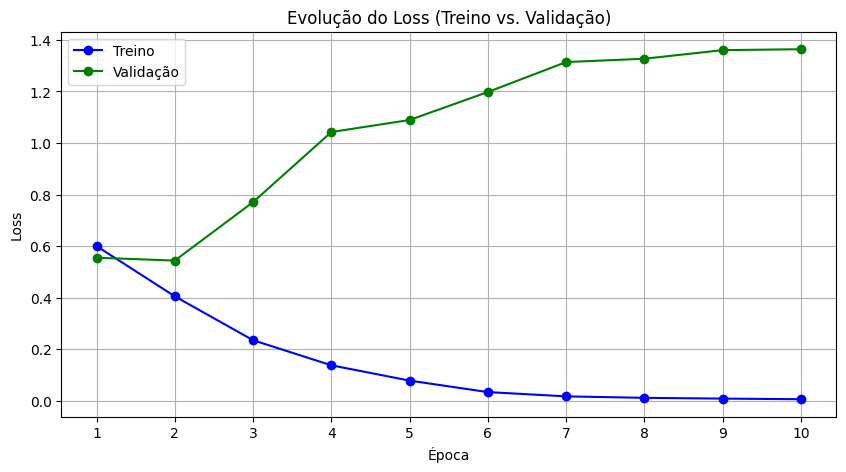

In [9]:
grafico_loss(estatistica_onca)

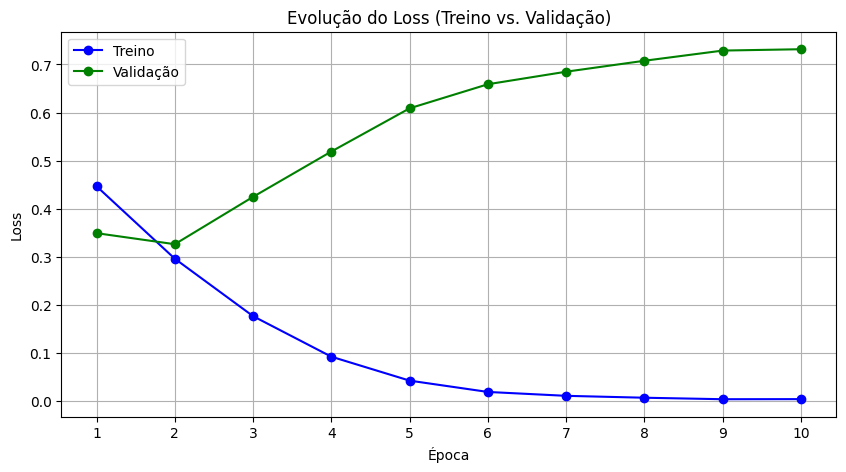

In [10]:
grafico_loss(estatistica_caseiro)

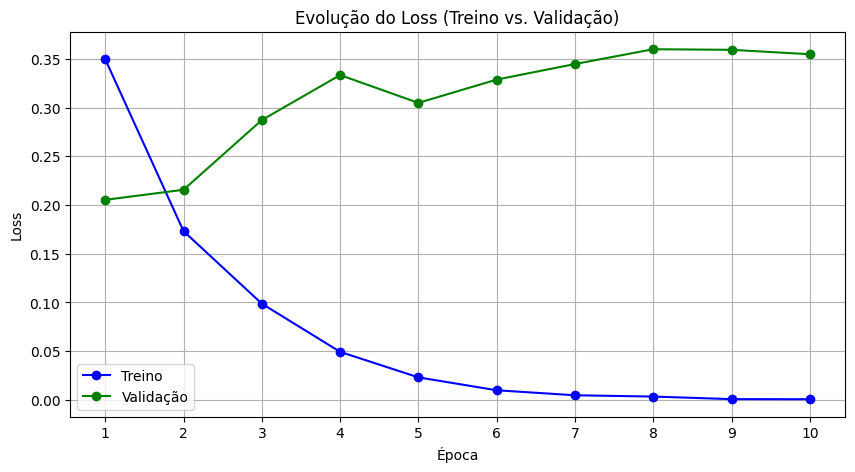

In [11]:
grafico_loss(estatistica_noticia)

## 5. Avaliação Final (Conjunto de Teste)

Com os modelos treinados, fizemos a avaliação final no conjunto de Teste:
1.  Foi criada a função `testar_modelo` que passa os dados de teste pelo modelo (com `torch.no_grad()`) e coleta as previsões (`preds`) e os rótulos reais (`rotulos`).
2.  Foi usado o `classification_report` do Scikit-learn para gerar as métricas finais para cada classe:
    * **Precision**
    * **Recall**
    * **F1-Score**
    * **Acurácia Geral**
3.  Por fim, Filtramos e exibimos 2 exemplos de comentários que cada modelo classificou incorretamente, para análise qualitativa.

In [12]:
def testar_modelo(modelo, dataloader_teste, device):
  modelo.eval()
  preds_list = []
  rotulos_list = []

  with torch.no_grad():
    for batch in dataloader_teste:
      t_input_ids = batch[0].to(device)
      t_input_mask = batch[1].to(device)
      t_rotulos = batch[2].to(device)

      outputs = modelo(t_input_ids, token_type_ids=None, attention_mask=t_input_mask)

      logits = outputs.logits

      logits = logits.detach().cpu().numpy()
      rotulos = t_rotulos.to('cpu').numpy()

      preds = np.argmax(logits, axis=1).flatten()

      preds_list.extend(preds)
      rotulos_list.extend(rotulos)

  return preds_list, rotulos_list

In [13]:
previsoes_onca, rotulos_onca = testar_modelo(
    modelo_onca,
    dataloader_teste_onca,
    device
)

previsoes_caseiro, rotulos_caseiro = testar_modelo(
    modelo_caseiro,
    dataloader_teste_caseiro,
    device
)

previsoes_noticia, rotulos_noticia = testar_modelo(
    modelo_noticia,
    dataloader_teste_noticia,
    device
)

In [14]:
print('\n Classificação (Onça)')
print(classification_report(rotulos_onca, previsoes_onca, target_names=['negativo', 'neutro', 'positivo']))
print('\n Classificação (Caseiro)')
print(classification_report(rotulos_caseiro, previsoes_caseiro, target_names=['negativo', 'neutro', 'positivo']))
print('\n Classificação (Notícia)')
print(classification_report(rotulos_noticia, previsoes_noticia, target_names=['ruim', 'neutra', 'boa']))



 Classificação (Onça)
              precision    recall  f1-score   support

    negativo       0.58      0.54      0.56       108
      neutro       0.89      0.88      0.88       513
    positivo       0.52      0.63      0.57        54

    accuracy                           0.81       675
   macro avg       0.66      0.68      0.67       675
weighted avg       0.81      0.81      0.81       675


 Classificação (Caseiro)
              precision    recall  f1-score   support

    negativo       0.52      0.40      0.46        57
      neutro       0.92      0.94      0.93       559
    positivo       0.63      0.66      0.64        59

    accuracy                           0.87       675
   macro avg       0.69      0.67      0.68       675
weighted avg       0.86      0.87      0.86       675


 Classificação (Notícia)
              precision    recall  f1-score   support

        ruim       0.68      0.57      0.62        46
      neutra       0.96      0.97      0.97       602


In [16]:
print('\nErros (Onça)')
erros = pd.DataFrame({
    'comentario': X_teste_onca,
    'rotulo': rotulos_onca,
    'previsto': previsoes_onca
})

mapeamento_inverso = {0: 'negativo', 1: 'neutro', 2: 'positivo'}
erros['rotulo_desc'] = erros['rotulo'].map(mapeamento_inverso)
erros['previsto_desc'] = erros['previsto'].map(mapeamento_inverso)

somente_erro = erros[erros['rotulo'] != erros['previsto']]

for i, linha in somente_erro.head(2).iterrows():
  print(f'\nComentário: {linha['comentario']}')
  print(f'Rotulo: {linha['rotulo_desc']}')
  print(f'Previsto: {linha['previsto_desc']} \n')
#
print('\nErros (Caseiro)')
erros = pd.DataFrame({
    'comentario': X_teste_caseiro,
    'rotulo': rotulos_caseiro,
    'previsto': previsoes_caseiro
})

erros['rotulo_desc'] = erros['rotulo'].map(mapeamento_inverso)
erros['previsto_desc'] = erros['previsto'].map(mapeamento_inverso)

somente_erro = erros[erros['rotulo'] != erros['previsto']]

for i, linha in somente_erro.head(2).iterrows():
  print(f'\nComentário: {linha['comentario']}')
  print(f'Rotulo: {linha['rotulo_desc']}')
  print(f'Previsto: {linha['previsto_desc']} \n')
#
print('\nErros (Notícia)')
erros = pd.DataFrame({
    'comentario': X_teste_noticia,
    'rotulo': rotulos_noticia,
    'previsto': previsoes_noticia
})

mapeamento_inverso = {0: 'ruim', 1: 'neutra', 2: 'boa'}
erros['rotulo_desc'] = erros['rotulo'].map(mapeamento_inverso)
erros['previsto_desc'] = erros['previsto'].map(mapeamento_inverso)

somente_erro = erros[erros['rotulo'] != erros['previsto']]

for i, linha in somente_erro.head(2).iterrows():
  print(f'\nComentário: {linha['comentario']}')
  print(f'Rotulo: {linha['rotulo_desc']}')
  print(f'Previsto: {linha['previsto_desc']} \n')


Erros (Onça)

Comentário: E se fosse filho de algum comandante das autoridades ambiaentais? Nota-se que na busca pela onça, os policiais ambientais estavam armados até os dentes p se defenderem, porém, a população nao pode andar sequer com um calibre 22 senao e pega cadeia por falta d porte de arma... infelizmente a vida humana perdeu o valor...novas mortes acontecerão, e explicacoesa  pelo acontecido surgirão; a vida continua!!!
Rotulo: negativo
Previsto: neutro 


Comentário: Mas é a vdd amigo, o ser humano é destruidor por natureza, tem prazer nisso, é bem complicado falar sobre, mas é a vdd. O ser humano não tá destruindo o habitat dos animais, está destruindo o planeta todo kk
Rotulo: positivo
Previsto: neutro 


Erros (Caseiro)

Comentário: Tô pedindo a Deus esse dono da pousada que ele nunca mais seja feliz
Rotulo: neutro
Previsto: positivo 


Comentário: Henrique com todo respeito , sou do MS , já vi e vivi no Pantanal , mas eu por ser nada , não sou estudado , não sou pantane

In [27]:
def classificar_texto(comentario, modelo, tokenizador, device, max_len=128):
  modelo.eval()
  revisao = tokenizador.encode_plus(
      comentario,
      add_special_tokens=True,
      max_length=max_len,
      return_attention_mask=True,
      padding='max_length',
      truncation=True,
      return_tensors='pt',
  )
  input_ids = revisao['input_ids'].to(device)
  attention_mask = revisao['attention_mask'].to(device)

  with torch.no_grad():
    outputs = modelo(input_ids, attention_mask=attention_mask)

  logits = outputs.logits
  return logits.detach().cpu().numpy()

comentario_1 = 'Reportagem excelente e com muitas informações sobre o ocorrido'
comentario_2 = 'Faltou muita informação que só quem mora aqui sabe'
comentario_3 = 'Não mudou em nada a minha opinião'
#
comentario_4 = 'A onça não tem culpa'
#
comentario_5 = 'O caseiro que alimentava ela'
comentario_6 = 'Isso é culpa de quem alimentava ela'

modelo_demonstracao = modelo_noticia
mapeamento_demonstracao = {0: 'ruim', 1: 'neutra', 2: 'boa'}

comentarios = [comentario_1, comentario_2, comentario_3]

for texto in comentarios:
  logits = classificar_texto(texto, modelo_demonstracao, tokenizador, device)

  previsao = np.argmax(logits, axis=1).flatten()[0]

  previsao_desc = mapeamento_demonstracao[previsao]

  print(f'\nComentário: "{texto}"')
  print(f'Previsão: {previsao_desc.upper()}')

modelo_demonstracao = modelo_onca
mapeamento_demonstracao = {0: 'negativo', 1: 'neutro', 2: 'positivo'}

logits = classificar_texto(comentario_4, modelo_demonstracao, tokenizador, device)

previsao = np.argmax(logits, axis=1).flatten()[0]

previsao_desc = mapeamento_demonstracao[previsao]

print(f'\nComentário: "{comentario_4}"')
print(f'Previsão: {previsao_desc.upper()}')

modelo_demonstracao = modelo_caseiro

comentarios = [comentario_5, comentario_6]

for texto in comentarios:
  logits = classificar_texto(texto, modelo_demonstracao, tokenizador, device)

  previsao = np.argmax(logits, axis=1).flatten()[0]

  previsao_desc = mapeamento_demonstracao[previsao]

  print(f'\nComentário: "{texto}"')
  print(f'Previsão: {previsao_desc.upper()}')


Comentário: "Reportagem excelente e com muitas informações sobre o ocorrido"
Previsão: BOA

Comentário: "Faltou muita informação que só quem mora aqui sabe"
Previsão: NEUTRA

Comentário: "Não mudou em nada a minha opinião"
Previsão: RUIM

Comentário: "A onça não tem culpa"
Previsão: POSITIVO

Comentário: "O caseiro que alimentava ela"
Previsão: NEGATIVO

Comentário: "Isso é culpa de quem alimentava ela"
Previsão: NEUTRO
